# MeshCat.jl Tutorial
### Create animations in Julia

In [119]:
using Colors: RGBA, RGB # Handle RGB colors
using CoordinateTransformations # Translations and rotations
using FileIO # Save and load files
using GeometryTypes: # Define geometric shapes
    GeometryTypes, HyperRectangle, Vec, Point, Rectangle, Cylinder,
    HomogenousMesh, SignedDistanceField, HyperSphere, GLUVMesh, Pyramid
using LinearAlgebra
using MeshCat # Visualize 3D animations
using MeshIO # Load meshes in MeshCat

### Create and open visualizer

In [120]:
vis = Visualizer()
open(vis);

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8747
└ @ MeshCat /home/simon/.julia/packages/MeshCat/GMobF/src/servers.jl:24
┌ Error: error handling request
│   exception = (Base.IOError("stream is closed or unusable", 0), Base.StackTraces.StackFrame[check_open at stream.jl:323 [inlined], uv_write_async(::Sockets.TCPSocket, ::Ptr{UInt8}, ::UInt64, ::Task) at stream.jl:901, uv_write(::Sockets.TCPSocket, ::Ptr{UInt8}, ::UInt64) at stream.jl:877, unsafe_write(::Sockets.TCPSocket, ::Ptr{UInt8}, ::UInt64) at stream.jl:931, macro expansion at ConnectionPool.jl:134 [inlined], write at io.jl:177 [inlined], closebody at Streams.jl:111 [inlined], closewrite(::HTTP.Streams.Stream{HTTP.Messages.Request,HTTP.ConnectionPool.Transaction{Sockets.TCPSocket}}) at Streams.jl:126, (::getfield(HTTP.Servers, Symbol("##13#14")){getfield(WebSockets, Symbol("#_servercoroutine#11")){WebSockets.ServerWS},HTTP.ConnectionPool.Transaction{Sockets.TCPSocket},HTTP.Streams.Stream{HTTP.Messages.Request,HTTP.Conn

### Load mesh

In [121]:
car = load("../animation/object/car/car_geometry.obj", GLUVMesh);

### Load texture image

In [122]:
car_image = PngImage("../animation/image/yellow.png");

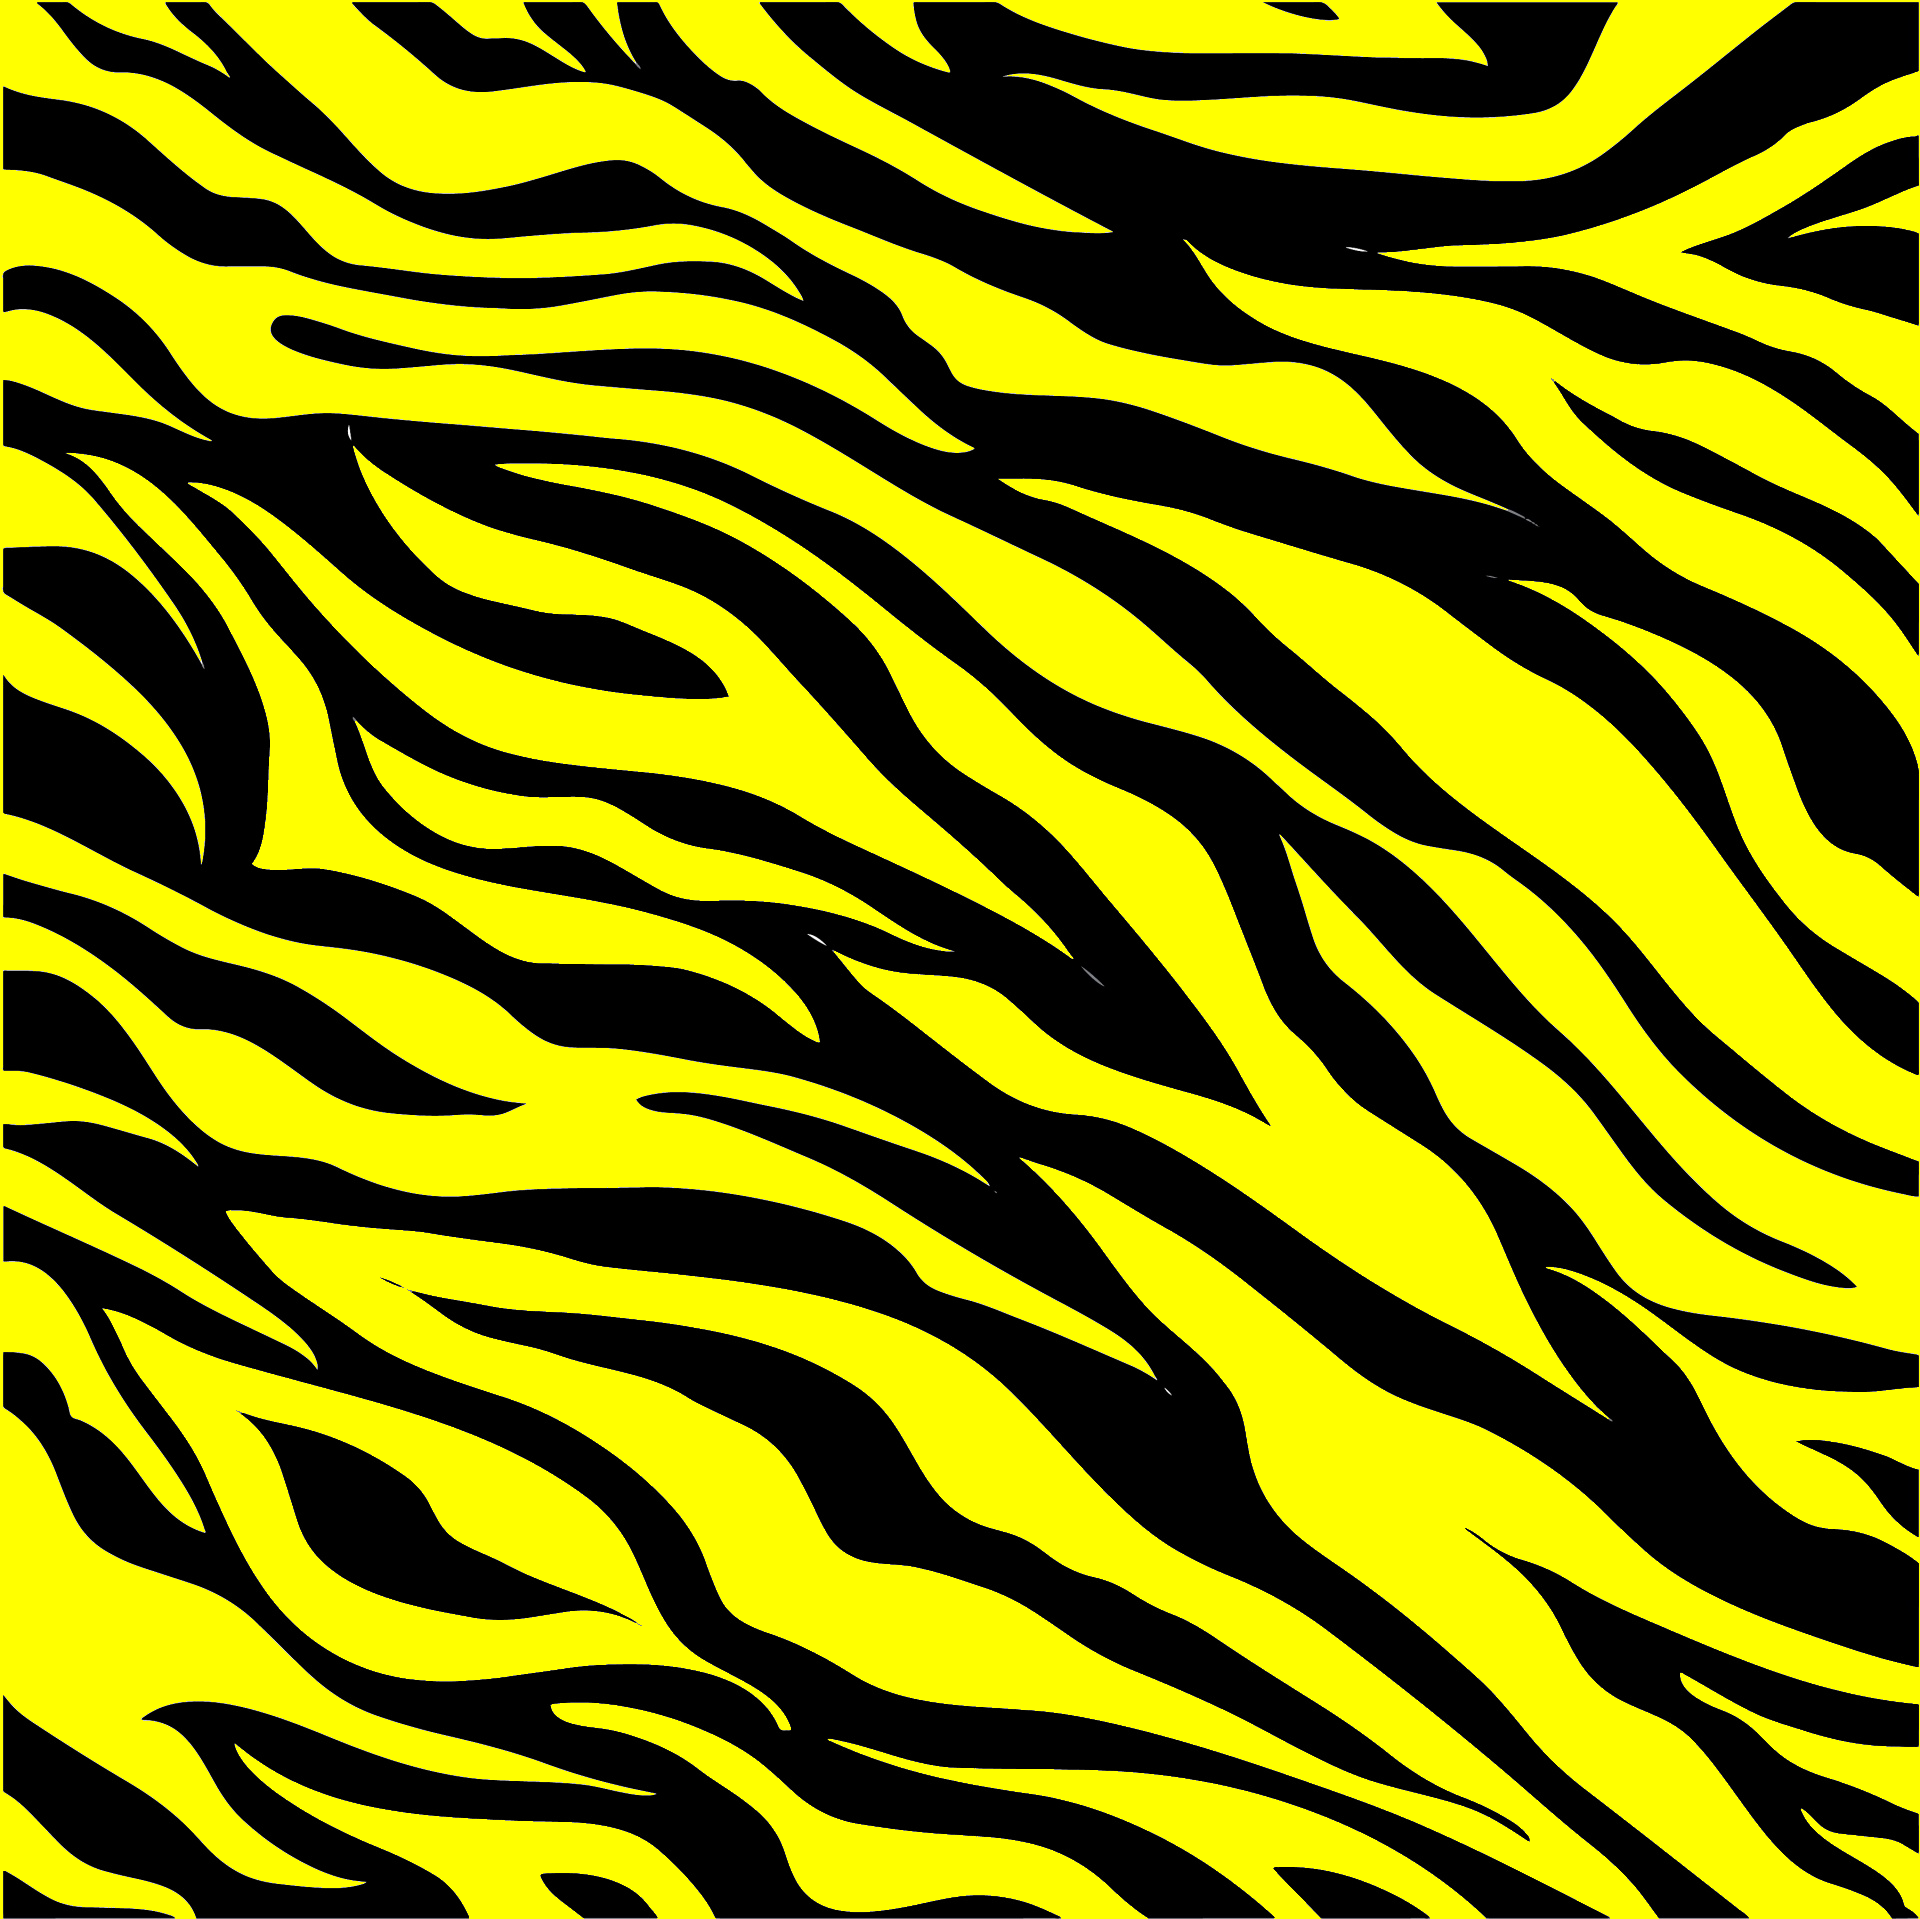

### Create texture

In [123]:
car_texture = Texture(image=car_image);

### Create material

In [124]:
car_material = MeshLambertMaterial(map=car_texture);

### Create object

In [125]:
setobject!(vis["car_bundle/car"], car, car_material);

### Translate the object

In [127]:
car_trans = Translation(0.0, 0.0, 3.0)
settransform!(vis["car_bundle/car"], car_trans);

### Rotate the object

In [128]:
car_rot = LinearMap(AngleAxis(pi/2, 0, 0, 1))
settransform!(vis["car_bundle/car"], car_rot);

### Compose rotations

In [130]:
car_rot0 = LinearMap(AngleAxis(0.0, 1, 0, 0))
car_rot1 = LinearMap(AngleAxis(pi/4, 1, 0, 0))
car_rot2 = LinearMap(AngleAxis(pi/2, 0, 0, 1))
car_rot11 = compose(car_rot1, car_rot1)
car_rot12 = compose(car_rot1, car_rot2)
car_rot21 = compose(car_rot2, car_rot1);

#### No rotation

In [150]:
settransform!(vis["car_bundle/car"], car_rot0);

#### Rotation 1

In [132]:
settransform!(vis["car_bundle/car"], car_rot1);

#### Rotation 2

In [133]:
settransform!(vis["car_bundle/car"], car_rot0);

In [134]:
settransform!(vis["car_bundle/car"], car_rot2);

#### Rotation 1 then Rotation 1

In [135]:
settransform!(vis["car_bundle/car"], car_rot0);

In [136]:
settransform!(vis["car_bundle/car"], car_rot11);

#### Rotation 2 then Rotation 1

In [137]:
settransform!(vis["car_bundle/car"], car_rot0);

In [138]:
settransform!(vis["car_bundle/car"], car_rot12);

#### Rotation 1 then Rotation 2

In [139]:
settransform!(vis["car_bundle/car"], car_rot0);

In [140]:
settransform!(vis["car_bundle/car"], car_rot21);

# Conclusion: 
With compose(rot1, rot2)
- first rotation 2 is applied 
- then rotation 1 is applied

When using axis-angle representation the axis is expressed in the world-frame. And the rotation will be applied about the world-frame axis. 

### Compose rotations and translations

In [141]:
car_transformation = compose(car_trans, car_rot)
settransform!(vis["car_bundle/car"], car_transformation);

#### Rotation 2 then Translation then Rotation 1

In [142]:
settransform!(vis["car_bundle/car"], car_rot0);

In [143]:
car_transformation = compose(compose(
    car_rot1, 
    car_trans),
    car_rot2);
settransform!(vis["car_bundle/car"], car_transformation);

#### Translation then Rotation 2 then Rotation 1

In [144]:
settransform!(vis["car_bundle/car"], car_rot0);

In [145]:
car_transformation = compose(compose(
    car_rot1, 
    car_rot2),
    car_trans);
settransform!(vis["car_bundle/car"], car_transformation);

#### Rotation 2 then Rotation 1 then Translation

In [146]:
settransform!(vis["car_bundle/car"], car_rot0);

In [147]:
car_transformation = compose(compose(
    car_trans, 
    car_rot1),
    car_rot2);
settransform!(vis["car_bundle/car"], car_transformation);

# Conclusion: 
With t_i being a rotation or a translation. 
compose(t1, ..., t_n)
- first t_n is applied
- ...
- finally t_1 is applied

When using translation the axes are the world-frame axes. And the translation will be applied about the world-frame axes. 

### Create translations and rotations to place the car at the origin

In [148]:
car_trans = Translation(0.0, 0.0, -0.04)
car_rot1 = LinearMap(AngleAxis(pi/200, 0, 1, 0))
car_rot2 = LinearMap(AngleAxis(pi/2, 0, 0, 1))
car_rot3 = LinearMap(AngleAxis(pi/2, 1, 0, 0))
car_offset = compose(compose(compose(
        car_trans,
        car_rot1),
        car_rot2),
        car_rot3);

### Place the car at the origin

In [151]:
settransform!(vis["car_bundle/car"], car_offset);

# Dealing with kinematic chains
- MeshCat organizes objects in a tree.
- Objects are leaves of the tree.
- Nodes in the tree are frames.
- Branches of the tree are transformations (combinations of rotations and translations).


### Simplest example
- We bundle a car object and a cylinder object together.
    - car_bundle is the parent node. 
        - car is one leaf and is obtained from 'car_bundle' via the 'car_offset' transformation.
        - cylinder is the second leaf and is obtained from 'car_bundle' via an identity transformation. 
    - We can move the car and the cylinder together (as one merged object) by changing the transformation linking the "car_bundle" to the root of the tree.


### Add collision avoidance cylinder

In [152]:
radius = 3.0
cylinder_height = 0.3
collision_cylinder = Cylinder(Point(0.0,0.0,0.0),
    Point(0.0,0.0,cylinder_height), radius);

In [153]:
yellow_color = [1, 1, 0.0]
cylinder_material = MeshPhongMaterial(
    color=RGBA(yellow_color..., 5e-1));

### Add the cylinder to the scene as a leaf of 'car_bundle'

In [154]:
setobject!(vis["car_bundle/collision_cylinder"], 
    collision_cylinder, cylinder_material);

### Set the tranformation between 'car_bundle' and the cylinder as identity.

In [155]:
settransform!(vis["car_bundle/collision_cylinder"], 
    Translation(0.0, 0.0, 0.0));

### We can move 'car_bundle' = car + cylinder as one object.

In [160]:
settransform!(vis["car_bundle"], Translation(0.0, 0.0, 0.0))
sleep(0.2)
settransform!(vis["car_bundle"], Translation(1.0, 0.0, 0.0))
sleep(0.2)
settransform!(vis["car_bundle"], Translation(2.0, 0.0, 0.0))
sleep(0.2)
settransform!(vis["car_bundle"], Translation(3.0, 0.0, 0.0))

MeshCat Visualizer with path /meshcat/car_bundle

# Controling the camera
- Be careful the camera axes are different from the world-frame axes
    - X_c = X_wf
    - Y_c = Z_wf
    - Z_c = -Y_wf

### Translate the camera

In [161]:
settransform!(vis["/Cameras/default/rotated/<object>"], 
    Translation(25.0, 3.0, 0.0));

In [162]:
settransform!(vis["/Cameras/default/rotated/<object>"], 
    Translation(15.0, 3.0, 0.0));

### Rotate the camera

In [163]:
camera_trans = Translation(15.0, 3.0, 0.0)
camera_rotx = LinearMap(AngleAxis(pi/4, 1, 0, 0))
camera_roty = LinearMap(AngleAxis(pi/4, 0, 1, 0))
camera_rotz = LinearMap(AngleAxis(pi/4, 0, 0, 1));

#### Rotate the camera about X_c

In [164]:
settransform!(vis["/Cameras/default/rotated/<object>"], 
    camera_trans);

In [165]:
camera_transformation = compose(camera_rotx, camera_trans)
settransform!(vis["/Cameras/default/rotated/<object>"], 
    camera_transformation);

#### Rotate the camera about Y_c

In [166]:
settransform!(vis["/Cameras/default/rotated/<object>"], 
    camera_trans);

In [167]:
camera_transformation = compose(camera_roty, camera_trans)
settransform!(vis["/Cameras/default/rotated/<object>"], 
    camera_transformation);

#### Rotate the camera about Z_c

In [168]:
settransform!(vis["/Cameras/default/rotated/<object>"], 
    camera_trans);

In [169]:
camera_transformation = compose(camera_rotz, camera_trans)
settransform!(vis["/Cameras/default/rotated/<object>"], 
    camera_transformation);

### /!\ The camera always points towards the origin of the frame.
Rotating the camera only means rotating the vector origin-camera. We are not controlling the orientation of the camera.


# Aminating the scene

### Create an animation and set the frame rate.

In [170]:
framerate = 6
anim = MeshCat.Animation(
    Dict{MeshCat.SceneTrees.Path,MeshCat.AnimationClip}(), 
    framerate);

### Create the trajectory of the car
- Set the number of frames
- Set the pose of the car bundle at each frame

In [171]:
N = 24 # Number of frames
for k=1:N
    # Set the pose of the car bundle.
    MeshCat.atframe(anim, vis, k) do frame
        settransform!(vis["car_bundle"], Translation(k*0.3, 0.0, 0.0))
    end
end;

┌ Warning: atframe(f::Function, anim::Animation, vis::Visualizer, frame::Integer) is deprecated.
│ Please use atframe(g, anim, frame) instead, where g is similar to f but takes
│ no arguments and should call methods on vis.
│ See also the updated animation example notebook.
│   caller = top-level scope at In[171]:4
└ @ Core In[171]:4


### Animate 

In [172]:
MeshCat.setanimation!(vis, anim);

### Add camera movement
- When you use '/Cameras/default/rotated/*object*'.The camera position is set back to its original position even if you move the camera in the browser after the animation. Moreover, you can't move the camerea during the animation.
    
- When you use "/Cameras/default". The camera position is offset with respect to where you moved the camera in the browser.

### Absolute camera movement

In [173]:
anim = MeshCat.Animation(
    Dict{MeshCat.SceneTrees.Path,MeshCat.AnimationClip}(), 
    framerate);
for k=1:N
    # Set the pose of the car bundle.
    MeshCat.atframe(anim, vis, k) do frame
        settransform!(vis["car_bundle"], Translation(k*0.3, 0.0, 0.0))
        settransform!(frame["/Cameras/default/rotated/<object>"], 
            Translation(k*0.3+2.0, 5.0, 0.0))
    end
end;

┌ Warning: atframe(f::Function, anim::Animation, vis::Visualizer, frame::Integer) is deprecated.
│ Please use atframe(g, anim, frame) instead, where g is similar to f but takes
│ no arguments and should call methods on vis.
│ See also the updated animation example notebook.
│   caller = top-level scope at In[173]:6
└ @ Core In[173]:6


In [174]:
MeshCat.setanimation!(vis, anim);

### Relative camera movement

In [180]:
anim = MeshCat.Animation(
    Dict{MeshCat.SceneTrees.Path,MeshCat.AnimationClip}(), 
    framerate);
for k=1:N
    # Set the pose of the car bundle.
    MeshCat.atframe(anim, vis, k) do frame
        settransform!(vis["car_bundle"], Translation(k*0.3, 0.0, 0.0))
        settransform!(frame["/Cameras/default"], 
            Translation(k*0.3+2.0, 5.0, 0.0))
    end
end;

┌ Warning: atframe(f::Function, anim::Animation, vis::Visualizer, frame::Integer) is deprecated.
│ Please use atframe(g, anim, frame) instead, where g is similar to f but takes
│ no arguments and should call methods on vis.
│ See also the updated animation example notebook.
│   caller = top-level scope at In[180]:6
└ @ Core In[180]:6


In [181]:
MeshCat.setanimation!(vis, anim);